In [10]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.datasets import boston_housing
from keras.layers import Dense, Dropout
from keras.utils import multi_gpu_model
from keras import regularizers  # 正则化
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## 加载数据

In [11]:
(x_train, y_train), (x_valid, y_valid) = boston_housing.load_data()  # 加载数据

# 转成DataFrame格式方便数据处理
x_train_pd = pd.DataFrame(x_train)
y_train_pd = pd.DataFrame(y_train)
x_valid_pd = pd.DataFrame(x_valid)
y_valid_pd = pd.DataFrame(y_valid)
print(x_train_pd.head(5))
print('-------------------')
print(y_train_pd.head(5))

        0     1      2    3      4      5      6       7     8      9     10  \
0  1.23247   0.0   8.14  0.0  0.538  6.142   91.7  3.9769   4.0  307.0  21.0   
1  0.02177  82.5   2.03  0.0  0.415  7.610   15.7  6.2700   2.0  348.0  14.7   
2  4.89822   0.0  18.10  0.0  0.631  4.970  100.0  1.3325  24.0  666.0  20.2   
3  0.03961   0.0   5.19  0.0  0.515  6.037   34.5  5.9853   5.0  224.0  20.2   
4  3.69311   0.0  18.10  0.0  0.713  6.376   88.4  2.5671  24.0  666.0  20.2   

       11     12  
0  396.90  18.72  
1  395.38   3.11  
2  375.52   3.26  
3  396.90   8.01  
4  391.43  14.65  
-------------------
      0
0  15.2
1  42.3
2  50.0
3  21.1
4  17.7


## 数据归一化

In [24]:
# 训练集归一化
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train_pd)
x_train = min_max_scaler.transform(x_train_pd)

min_max_scaler.fit(y_train_pd)
y_train = min_max_scaler.transform(y_train_pd)

# 验证集归一化
min_max_scaler.fit(x_valid_pd)
x_valid = min_max_scaler.transform(x_valid_pd)

min_max_scaler.fit(y_valid_pd)
y_valid = min_max_scaler.transform(y_valid_pd)


[[1.37816304e-02 0.00000000e+00 2.81524927e-01 ... 8.93617021e-01
  1.00000000e+00 4.68818985e-01]
 [1.73654275e-04 8.25000000e-01 5.75513196e-02 ... 2.23404255e-01
  9.96167230e-01 3.80794702e-02]
 [5.49837765e-02 0.00000000e+00 6.46627566e-01 ... 8.08510638e-01
  9.46089061e-01 4.22185430e-02]
 ...
 [3.18534767e-04 3.50000000e-01 2.05278592e-01 ... 4.57446809e-01
  9.12627969e-01 1.68322296e-01]
 [2.40852297e-02 0.00000000e+00 7.00879765e-01 ... 2.23404255e-01
  6.59715568e-01 3.87969095e-01]
 [9.07048543e-05 6.00000000e-01 9.05425220e-02 ... 3.19148936e-01
  9.49064501e-01 7.31236203e-02]]
[[0.72190697 0.         0.63650075 ... 0.87804878 0.00698455 0.90222813]
 [0.00440139 0.         0.33144796 ... 0.58536585 0.99476158 0.47522448]
 [0.00167219 0.         0.14969834 ... 0.87804878 1.         0.26005986]
 ...
 [0.07273042 0.         0.69230769 ... 0.20731707 0.98041639 0.        ]
 [0.01378101 0.         0.18778281 ... 0.53658537 0.98603089 0.25906219]
 [0.11628215 0.         0.6923

## 训练

In [42]:

# 单CPU or GPU版本，若有GPU则自动切换
model = Sequential()  # 初始化，很重要！
model.add(Dense(units = 10,   # 输出大小
                activation='relu',  # 激励函数
                input_shape=(x_train_pd.shape[1],)  # 输入大小, 也就是列的大小
               )
         )

model.add(Dropout(0.2))  # 丢弃神经元链接概率

model.add(Dense(units = 15,
#                 kernel_regularizer=regularizers.l2(0.01),  # 施加在权重上的正则项
#                 activity_regularizer=regularizers.l1(0.01),  # 施加在输出上的正则项
                activation='relu' # 激励函数
                # bias_regularizer=keras.regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项
               )
         )

model.add(Dense(units = 1,   
                activation='linear'  # 线性激励函数 回归一般在输出层用这个激励函数  
               )
         )

print(model.summary())  # 打印网络层次结构

model.compile(loss='mse',  # 损失均方误差
              optimizer='adam',  # 优化器
             )

history = model.fit(x_train, y_train,
          epochs=200,  # 迭代次数
          batch_size=200,  # 每次用来梯度下降的批处理数据大小
          verbose=2,  # verbose：日志冗长度，int：冗长度，0：不输出训练过程，1：输出训练进度，2：输出每一个epoch
          validation_data = (x_valid, y_valid)  # 验证集
        )

# 多GPU版本
# parallel_model = multi_gpu_model(model, gpus=4)
# parallel_model.compile(loss='mse',  # 多分类     
#                        optimizer='adam',
#                       )

# This `fit` call will be distributed on 4 GPUs.
# Since the batch size is 50, each GPU will process 32 samples.
# batch_size = 512
# epochs = 2
# history = parallel_model.fit(
#           x_train, 
#           y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split = 0.2  # 从训练集分割出20%的数据作为验证集
#         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                140       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 16        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Train on 404 samples, validate on 102 samples
Epoch 1/200
 - 2s - loss: 0.3991 - val_loss: 0.2925
Epoch 2/200
 - 0s - loss: 0.3243 - val_loss: 0.2459
Epoch 3/200
 - 0s - loss: 0.2812 - val_loss: 0.2064
Epoch 4/200
 - 0s - loss: 0.2337 - val_loss: 0.1732
Epoch 5/200
 - 0s

Epoch 138/200
 - 0s - loss: 0.0294 - val_loss: 0.0313
Epoch 139/200
 - 0s - loss: 0.0253 - val_loss: 0.0310
Epoch 140/200
 - 0s - loss: 0.0276 - val_loss: 0.0306
Epoch 141/200
 - 0s - loss: 0.0248 - val_loss: 0.0301
Epoch 142/200
 - 0s - loss: 0.0239 - val_loss: 0.0295
Epoch 143/200
 - 0s - loss: 0.0270 - val_loss: 0.0294
Epoch 144/200
 - 0s - loss: 0.0278 - val_loss: 0.0297
Epoch 145/200
 - 0s - loss: 0.0284 - val_loss: 0.0300
Epoch 146/200
 - 0s - loss: 0.0254 - val_loss: 0.0301
Epoch 147/200
 - 0s - loss: 0.0264 - val_loss: 0.0299
Epoch 148/200
 - 0s - loss: 0.0302 - val_loss: 0.0302
Epoch 149/200
 - 0s - loss: 0.0260 - val_loss: 0.0303
Epoch 150/200
 - 0s - loss: 0.0276 - val_loss: 0.0300
Epoch 151/200
 - 0s - loss: 0.0291 - val_loss: 0.0298
Epoch 152/200
 - 0s - loss: 0.0264 - val_loss: 0.0297
Epoch 153/200
 - 0s - loss: 0.0269 - val_loss: 0.0296
Epoch 154/200
 - 0s - loss: 0.0280 - val_loss: 0.0293
Epoch 155/200
 - 0s - loss: 0.0277 - val_loss: 0.0290
Epoch 156/200
 - 0s - loss: 

## 训练过程可视化

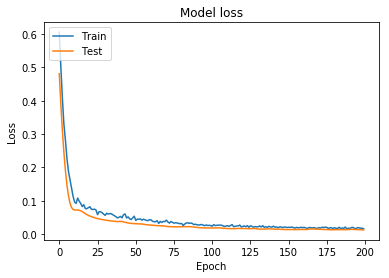

In [38]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 保存模型 & 模型可视化 & 加载模型

In [17]:
from keras.utils import plot_model
from keras.models import load_model
# 保存模型
model.save('model_MLP.h5')  # creates a HDF5 file 'my_model.h5'

#模型可视化 pip install pydot
plot_model(model, to_file='model_MLP.png', show_shapes=True)

# 加载模型
model = load_model('model_MLP.h5')

## 模型的预测功能

In [39]:
# 预测
y_new = model.predict(x_valid)
# 反归一化
min_max_scaler.fit(y_valid_pd)
y_new = min_max_scaler.inverse_transform(y_new)



[[0.07493158]
 [0.2893982 ]
 [0.39078662]
 [0.53390676]
 [0.4262308 ]
 [0.33204186]
 [0.50946146]
 [0.4132849 ]
 [0.2729963 ]
 [0.27879465]
 [0.32446215]
 [0.3486992 ]
 [0.25756323]
 [0.6590541 ]
 [0.24239415]
 [0.33537012]
 [0.41441542]
 [0.3994282 ]
 [0.24715093]
 [0.2789744 ]
 [0.16952842]
 [0.23424083]
 [0.3418997 ]
 [0.31744128]
 [0.41457468]
 [0.31370088]
 [0.53618276]
 [0.5057087 ]
 [0.1993371 ]
 [0.38090742]
 [0.33472478]
 [0.23952556]
 [0.75942624]
 [0.39149237]
 [0.21550557]
 [0.05032485]
 [0.17014757]
 [0.28126177]
 [0.26160812]
 [0.48688784]
 [0.37928256]
 [0.49463415]
 [0.19800049]
 [0.64089465]
 [0.57231766]
 [0.40187317]
 [0.52594954]
 [0.30410153]
 [0.23205215]
 [0.3788426 ]
 [0.6003846 ]
 [0.3352767 ]
 [0.15056258]
 [0.2847675 ]
 [0.5697139 ]
 [0.47074068]
 [0.17245734]
 [0.7106333 ]
 [0.7865126 ]
 [0.39577943]
 [0.2971291 ]
 [0.2173678 ]
 [0.22693393]
 [0.29524282]
 [0.41086504]
 [0.4469202 ]
 [0.21003845]
 [0.39480698]
 [0.21039695]
 [0.08688372]
 [0.27861476]
 [0.46